## The Perceptron

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0) # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new) # Predicts true/false for these two flowers

for i in range(2):
    print(f"Prediction for {X_new[i]} - {y_pred[i]}")

Prediction for [2, 0.5] - True
Prediction for [3, 1] - False


Scikit-learn's ```Perceptron``` class is equivalent to using ```SDGClassifier``` with the follwing hyperparameters:
```loss="perceptron", learning_rate="constant", eta0=1, penalty=None``` (no regularization)

#### Activation functions
![](images/activation_functions.png)

## Regression MLPs

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)

print(f"RMSE: {root_mean_squared_error(y_valid, y_pred):.3f}")

RMSE: 0.505


#### Typical regression MLP architecture

| Hyperparameter | Typical value |
|-|-|
| # hidden layers | Depends on the problem, but typically 1 to 5 |
| # neurons per hidden layer | Depends on the problem, but typically 10 to 100 |
| # output neurons | 1 per prediction dimension |
| Hidden activation | ReLU |
| Output activation | None, or ReLU/softplus (if positive outputs) or sigmoid/tanh (if bounded outputs) |
| Loss function | MSE, or Huber if outliers |


## Classification MLPs

In [3]:
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], random_state=42, max_iter=10000)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)

print(f"accuracy: {accuracy}")

accuracy: 1.0


#### Typical classification MLP architecture

| Hyperparameter | Binary classification | Multilabel binary classification | Multiclass classification | 
|-|-|-|-|
| # hidden layers | 1-5 | 1-5 | 1-5 |
| # output neurons | 1 | 1 per binary label | 1 per class |
| Output layer activation | Sigmoid | Sigmoid | Softmax | 
| Loss function | X-entropy | X-entropy | X-entropy |

## Implementing MLP's with Keras

#### Using Keras to load the dataset

In [4]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train.shape

2025-06-16 19:41:46.577598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750095706.591648    6516 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750095706.596215    6516 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750095706.607356    6516 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750095706.607374    6516 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750095706.607375    6516 computation_placer.cc:177] computation placer alr

(55000, 28, 28)

In [5]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.0

In [6]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Corresponding class names

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

class_names[y_train[0]]

'Ankle boot'

#### Samples from Fashion MNIST

![](images/fashion_mnist)

#### Creating the model using the sequential API 

In [8]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

W0000 00:00:1750095708.436739    6516 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In the last ```Dense``` output layer we use 10 neurons (one per each class) with the softmax activation function, since the classes are exclusive

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

```None``` in the Output Shape means the batch size can be anything

In [10]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [11]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [12]:
weights, biases = hidden1.get_weights()

print(weights.shape)
weights

(784, 300)


array([[ 0.04248101, -0.07181355,  0.06890737, ...,  0.05171221,
        -0.00828773, -0.03398401],
       [-0.06815251, -0.02939338, -0.0284612 , ...,  0.00081106,
        -0.0246893 , -0.045633  ],
       [-0.03497905,  0.01811749, -0.00756983, ..., -0.02822325,
         0.05217373, -0.05561926],
       ...,
       [ 0.072357  ,  0.0501798 ,  0.04046276, ...,  0.00408547,
        -0.00013907,  0.00670189],
       [-0.06817397, -0.01078849, -0.06904479, ...,  0.0594392 ,
         0.03100048, -0.05589244],
       [-0.06613498, -0.07002644,  0.00205766, ...,  0.01994134,
         0.00226095,  0.02057781]], dtype=float32)

In [13]:
print(biases.shape)
biases

(300,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

#### Compiling the model

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

We use ```"sparse_categorical_crossentropy"``` loss because we have sparse labels, and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors), then we would need to use the ```"categorical_crossentropy"``` loss instead. If we were doing binary classification, then we would use the ```"sigmoid"``` activation function in the output layer instead of the ```"softmax"``` activation function, and we would use the ```"binary_crossentropy"``` loss.

#### Training and evaluating the model

In [15]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6824 - loss: 0.9874 - val_accuracy: 0.8270 - val_loss: 0.5018
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8271 - loss: 0.5049 - val_accuracy: 0.8388 - val_loss: 0.4523
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8431 - loss: 0.4515 - val_accuracy: 0.8448 - val_loss: 0.4304
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8531 - loss: 0.4217 - val_accuracy: 0.8522 - val_loss: 0.4156
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8599 - loss: 0.4005 - val_accuracy: 0.8546 - val_loss: 0.4053
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8660 - loss: 0.3835 - val_accuracy: 0.8568 - val_loss: 0.3976
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8691 - loss: 0.3695 - val_accuracy: 0.8584 - val_loss: 0.3899
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8725 - loss: 0.3573 - 

In [16]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

#### Learning curves

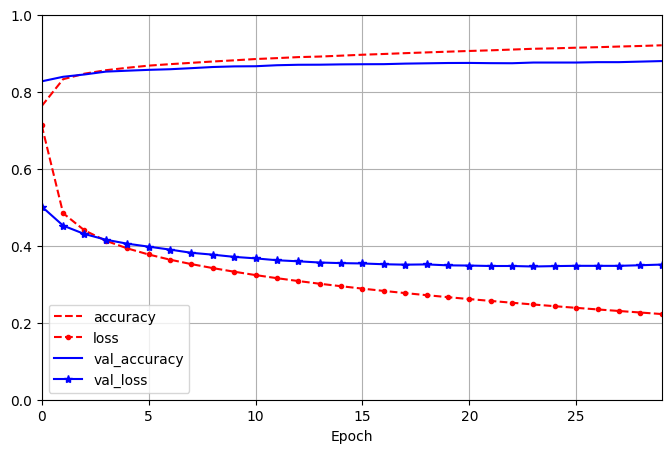

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
plt.show()

The validation curves are relatively close to each other at first, but they get further apart over time, which shows that there is a bit of overfitting. The model has not quite converged yet, as the validation loss is still going down, so we should probably continue training.

In [18]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8745 - loss: 0.3616


[0.36320462822914124, 0.8748000264167786]

#### Using the model to make predictions

In [19]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.01, 0.  , 0.87],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [20]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [21]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

![](images/fashion_mnist_predictions)

## Building a regression MLP using the Sequential API

In [22]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [24]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.Sequential([
    tf.keras.Input(shape=X_train.shape[1:]),
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 1.2246 - loss: 1.6180 - val_RootMeanSquaredError: 0.6234 - val_loss: 0.3886
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6381 - loss: 0.4077 - val_RootMeanSquaredError: 0.7311 - val_loss: 0.5345
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6076 - loss: 0.3695 - val_RootMeanSquaredError: 0.8956 - val_loss: 0.8021
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5948 - loss: 0.3540 - val_RootMeanSquaredError: 0.9151 - val_loss: 0.8375
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5833 - loss: 0.3404 - val_RootMeanSquaredError: 1.1450 - val_loss: 1.3110
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5747 - loss: 0.3304 - val_RootMeanSquaredError: 0.8674 - val_loss: 0.7523
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5664 - los

Instead of using ```Flatten``` layer, we use ```Normalization``` layer as the first layer: it does the same thing as Scikit-Learn's ```StandardScaler```, but it must be fitted to the training data using its ```adapt()``` method *before* we call the model's ```fit``` method

## Building Complex Models Using the Functional API

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

The ```Normalization``` layer is connected to the 2nd hidden layer creating a *wide* path

In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 102.0712 - loss: 14586.1182 - val_RootMeanSquaredError: 1.9248 - val_loss: 3.7050
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 1.7325 - loss: 3.0070 - val_RootMeanSquaredError: 1.5454 - val_loss: 2.3882
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 1.4369 - loss: 2.0662 - val_RootMeanSquaredError: 1.4234 - val_loss: 2.0262
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 1.2933 - loss: 1.6736 - val_RootMeanSquaredError: 1.2863 - val_loss: 1.6547
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 1.2042 - loss: 1.4507 - val_RootMeanSquaredError: 1.2152 - val_loss: 1.4766
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 1.1564 - loss: 1.3381 - val_RootMeanSquaredError: 1.1498 - val_loss: 1.3220
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 1.1102

We can send some features through the *wide* path and other through the *deep* path as follows

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

Now we can compile the model as usual, but when we call the ```fit()``` method, instead of passing a single input matrix ```X_train```, we must pass a pair of matrices ```(X_train_wide, X_train_deep)```, one per input. The same is true for ```X_valid```, and also for ```X_test``` and ```X_new``` when we call ```evaluate()``` or ```predict()```

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.3091 - loss: 1.7833 - val_RootMeanSquaredError: 0.9283 - val_loss: 0.8617
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.7140 - loss: 0.5106 - val_RootMeanSquaredError: 0.6966 - val_loss: 0.4852
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6651 - loss: 0.4426 - val_RootMeanSquaredError: 0.7297 - val_loss: 0.5325
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6458 - loss: 0.4173 - val_RootMeanSquaredError: 0.6526 - val_loss: 0.4258
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6339 - loss: 0.4020 - val_RootMeanSquaredError: 1.0901 - val_loss: 1.1883
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6266 - loss: 0.3928 - val_RootMeanSquaredError: 1.1568 - val_loss: 1.3381
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6174 - los

Instead of passing a tuple ```(X_train_wide, X_train_deep)```, we can pass a dictionary ```{"input_wide": X_train_wide, "input_deep": X_train_deep}```, if we set ```name="input_wide"``` and ```name=input_deep``` when creating inputs. This is highly recommended when there are many inputs, to clarify the code and avoid getting the order wrong